# Simulating populations

<div style="border: 1px solid; background-color:rgb(64, 0, 255); padding: 10px; border-radius: 5px; color: #ffffff;">
  <strong>Caveats:</strong> <br>
  - In this version of AmphiDEB (v0.3.3), the rule-based portion of the model only includes a minimum functional model. This should not be considered a fully fledged population model, but a starting point for future development. <br>
  - Both the ODE-based and rule-based components can be adjusted on the fly by providing the corresponding keyword arguments to `ODE_simulator` and `IBM_simulator`, respectively (see documentation for details).<br>
- Also consider the caveats for the TKTD module mentioned in `ex01`
</div>

Due to the depency of `EcotoxSystems.jl`, simulating populations works very similarly to simulating individual life history. <br>

We first need a set of parameters

In [2]:
using Pkg; Pkg.activate(".");
using AmphiDEB # load AmphiDEB

p = deepcopy(AmphiDEB.defaultparams) # get a copy of the default parameters

  Activating project at `c:\Users\Simon\Documents\Julia\AmphiDEB\examples`


ComponentVector{Any}(glb = (t_max = 56.0, N0 = 1.0, dX_in = Any[20.0, 20.0], k_V = Any[0.0, 0.0], V_patch = Any[1.0, 1.0], T = 293.15, C_W = Any[0.0], pathogen_inoculation_dose = 0.0, pathogen_inoculation_time = 30.0, medium_renewals = Any[0.0]), pth = (gamma = 0.0010000000000000002, eta = 8.0, v0 = 0.5, f = 0.5, sigma0 = 0.16666666666666666, sigma1 = 0.16666666666666666, mu = 0.01986754966887417), spc = (Z = Distributions.Dirac{Float64}(value=1.0), propagate_zoom = (dI_max_emb = 0.3333333333333333, dI_max_lrv = 0.3333333333333333, dI_max_juv = 0.3333333333333333, X_emb_int = 1.0, H_j1 = 1.0, H_p = 1.0, K_X_lrv = 0.3333333333333333, K_X_juv = 0.3333333333333333), X_emb_int = 1, K_X_lrv = 1.0, K_X_juv = 1.0, dI_max_emb = 1, dI_max_lrv = 1, dI_max_juv = 1, kappa_emb = 0.8, kappa_juv = 0.8, gamma = 0.5, eta_IA = 0.54, eta_AS_emb = 0.4, eta_AS_juv = 0.4, eta_AR = 0.95, eta_SA = 0.8, k_M_emb = 0.11, k_M_juv = 0.11, k_J_emb = 0.027, k_J_juv = 0.027, H_j1 = 1, H_p = 55.0, T_A = 8000.0, T_ref 

To simulate plausible population dynamics, we will want to make some adjustments to the global parameters.

In [89]:
p.glb.t_max = 365. * 3 # simulation time
p.glb.dX_in = [5000., 5000.] # food input rates
p.glb.k_V = [0.1, 0.1] # dilution rates for aquatic and terrestric habitat, respectively (can also be interpreted as mortality rate of the prey)
p.glb.N0 = 1000 # number of initial individuals (all start as embryo)

1000

We als need plausible values for the half saturation constants of food uptake and background mortality, respectively.

In [90]:
p.spc.K_X_lrv = p.spc.K_X_juv = 20.
p.spc.h_b = -log(1 - 0.001)

0.0010005003335835344

The default configuration of the population model includes a very minimal rule-based portion, taking care of mortality and reproduction:

In [91]:
less(AmphiDEB.default_individual_rules!)

function default_individual_rules!(
    a::EcotoxSystems.AbstractDEBIndividual, 
    m::EcotoxSystems.AbstractDEBIBM
    )::Nothing

    @unpack glb,ind = a.u
    du = a.du
    p = a.p

    ind.age += m.dt

    # death due to aging
    if death_by_aging(ind[:age], p.ind[:a_max])
        ind.cause_of_death = 1.
        glb.aging_mortality += 1
    end

    # life-stage transitions are part of ODE in amphibian model and omitted here
    
    # for starvation mortality, currently only a limit is set on the amount of mass that can be lost
    # this is basically only a sanity check, and the actual starvation rules should be assessed on a species-by-species basis
    ind.S_max_hist = determine_S_max_hist(ind[:S], ind[:S_max_hist])

    if death_by_loss_of_structure(ind[:S], ind[:S_max_hist], p[:ind][:S_rel_crit], p.ind[:h_S], m.dt)
        ind.cause_of_death = 2.
        glb.starvation_mortality += 1
    end

    # mortality caused by GUTS submodule, including background mortality
    if de

We certainly want to include biological variability in the population, and possibly try different values for the starvation parameters `h_S` and `S_rel_crit`.

In [92]:
using Distributions

p.spc.h_S = -log(0.75) # starvation hazard rate
p.spc.S_rel_crit = 0.5 # critical loss of structure at which starvaion mortality sets in

p.spc.X_emb_int = truncated(Normal(1, 0.1), 0, Inf) # initial embryonic buffer (≈ mass of eggs)
p.spc.Z = truncated(Normal(1, 0.1), 0, Inf) # zoom factor
p.spc.tau_R = truncated(Normal(365., 36.5), 0, Inf) # reproduction interval
p.spc.H_p = 50. # maturity at puberty

50.0

Now, to run the simulation, we call `AmphiDEB.IBM_simulator`.

In [ ]:
import AmphiDEB: @replicates
sim = @replicates AmphiDEB.IBM_simulator(p; record_individuals = false, showinfo = 60) 1;

The output is a `NamedTuple` with elements `glb` for global output and `spc` for specieslevel output. <br>
In the simulation above, we have set `record_individuals=false`, which means that `spc` will be empty. 

Making use of the global output, we can inspect the life sage-specific abundances and causes of mortality.

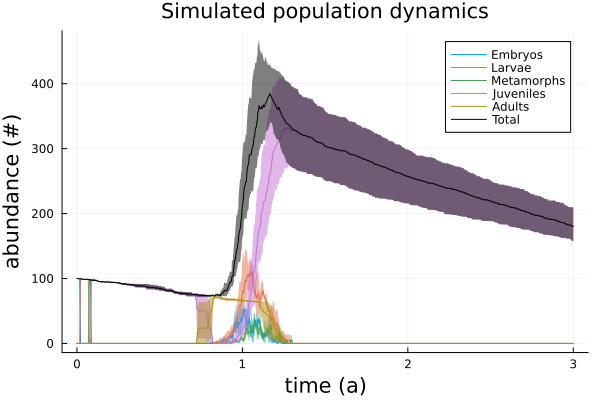

In [ ]:
using StatsPlots, LaTeXStrings
import AmphiDEB: lineplot, lineplot!

plt_N = plot(
    title = "Simulated population dynamics",
    xlabel = "time (a)", 
    ylabel = "abundance (#)", 
    labelfontsize = 14
    )


@df sim.glb lineplot!(:t ./ 365, :N_emb, label = "Embryos")
@df sim.glb lineplot!(:t ./ 365, :N_lrv, label = "Larvae")
@df sim.glb lineplot!(:t ./ 365, :N_mt, label = "Metamorphs")
@df sim.glb lineplot!(:t ./ 365, :N_juv, label = "Juveniles")
@df sim.glb lineplot!(:t ./ 365, :N_ad, label = "Adults")

@df sim.glb lineplot!(:t ./ 365, :N, label = "Total", color = :black)

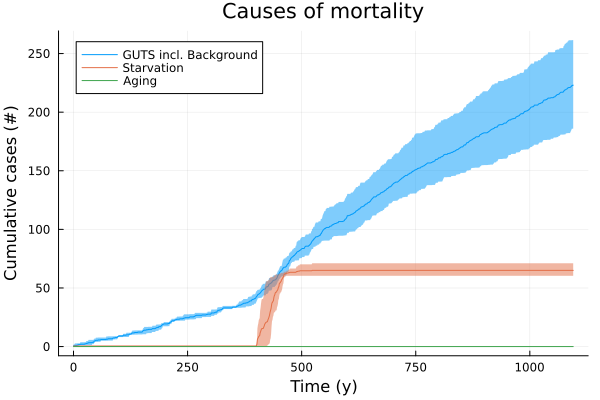

In [79]:
plt_mort = plot(
    title = "Causes of mortality", 
    xlabel = "Time (y)", 
    ylabel = "Cumulative cases (#)",

)

@df sim.glb lineplot!(:t, :GUTS_mortality, label = "GUTS incl. Background")
@df sim.glb lineplot!(:t, :starvation_mortality, label = "Starvation")
@df sim.glb lineplot!(:t, :aging_mortality, label = "Aging")